In [1]:
import math
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

In [17]:
#Modifique essas constantes!
UPDATE_FREQ = 10000   #número de agulhas jogadas
BOUND = 10  #comprimento do quadrado
BORDER = 0.05 * BOUND   #espaço extra em torno da borda do quadrado
NEEDLES = 10000  #total de agulhas
NEEDLE_LENGTH = 1   #comprimento da agulha
FLOORBOARD_WIDTH = 2 #distância entre as linhas do quadrado
FLOORBOARD_COLOR = 'black'  #cor do quadrado
NEEDLE_INTERSECTING_COLOR = 'red' #cor das agulhas que cruzam a linha
NEEDLE_NON_INTERSECTING_COLOR = 'green' #cor das agulhas que não cruzam a linha

In [3]:
#Segmento de linha com centro, ângulo e comprimento gerado usando números aleatórios
class Needle :
    #param  x       coordenada x do centro da agulha
    #param  y       coordenada y do centro da agulha
    #param  theta   ângulo de rotação da agulha, medida em radianos, entre 0 e pi
    #param  length  comprimento total da agulha
    def __init__(self, x=None, y=None, theta=None, length=NEEDLE_LENGTH) :
        #Definindo a orientação e coordenadas como variáveis aleatórias
        if x is None :
            x = random.uniform(0, BOUND)    #BOUND limite para a coordenada x, que é a borda direita
        if y is None :
            y = random.uniform(0, BOUND)    #BOUND limite para a coordenada y, que é a borda ao topo
        if theta is None :
            theta = random.uniform(0, math.pi)  # (pi, 2pi] redundante!
        
        self.center = np.array([x, y])
        #componentes da agulha (r cos(theta), r sin(theta))
        self.comp = np.array([length/2 * math.cos(theta), length/2 * math.sin(theta)])
        #adicionando as componentes da agulha um offset, -/+ onde a agulha pode girar em torno do centro
        self.endPoints = np.array([np.add(self.center, -1 * np.array(self.comp)), np.add(self.center, self.comp)])

    #return    se o ponto cruzar a borda-y
    def intersectsY(self, y):
        return self.endPoints[0][1] < y and self.endPoints[1][1] > y

In [15]:
#Simulação das idênticas agulhas jogadas sobre o quadrado para contar a frequência de interseções
class Buffon_Sim :
    #Construtor com variáveis de instâncias
    def __init__(self) :
        #Variáveis de instâncias
        self.floorboards = []   #armazena os valores de y das linhas do quadrado
        self.boards = int ((BOUND / FLOORBOARD_WIDTH) + 1)   #distance/unit + 1 bordas
        self.needles = []   #armazena os objetos agulhas (NEEDLES)
        self.intersections = 0  #número de interseções entre agulhas e as linhas no quadrado
        #Textos
        window = "Buffon"
        title = "Simulação do problema da agulha de Buffon\ncomo um método de aproximação para Pi"
        desc = (str(NEEDLES) + " agulhas de comprimento " + str(NEEDLE_LENGTH) +
                " uniformemente distribuídas sobre um quadrado de área " + str(BOUND) + " x " + str(BOUND) + " com linhas" +
                " distanciadas por " + str(FLOORBOARD_WIDTH))
        #Configuração do plot
        fig = plt.figure(figsize=(8, 8))    #tamanho da janela 
        fig.canvas.set_window_title(window) #título da janela
        fig.suptitle(title, size=16, ha='center')   #título principal
        self.buffon = plt.subplot() #plot das agulhas com o quadrado
        self.buffon.set_title(desc, style='italic', size=9, pad=5)  #descrição das condições da simulação
        self.results_text = fig.text(0, 0, self.updateResults(), size=10)   #resultado apresentado
        self.buffon.set_xlim(0 - BORDER, BOUND + BORDER)    #limite do eixo x
        self.buffon.set_ylim(0 - BORDER, BOUND + BORDER)    #limite do eixo y
        plt.gca().set_aspect('equal')   #para manter a proporção dos eixos

    #Plotar todas as linhas horizontais
    def plotFloorboards(self) :
        #Assumindo linhas horizontais
        for j in range(self.boards) :   #para cada linha
            self.floorboards.append(0 + j * FLOORBOARD_WIDTH)   #começa em 0 e adiciona um incremento
            self.buffon.hlines(y=self.floorboards[j], xmin=0, xmax=BOUND, color=FLOORBOARD_COLOR, linestyle='--', linewidth=2.0) #linhas horizontais com limite em x
    
    #Cria e posiciona aleatoriamente a agulha no plot
    def tossNeedle(self) :
        needle = Needle()
        self.needles.append(needle)   #adiciona a nova agulha ao array
        p1 = [needle.endPoints[0][0], needle.endPoints[1][0]]   #coordenada x
        p2 = [needle.endPoints[0][1], needle.endPoints[1][1]]   #coordenada y
        #testa se a agulha intersepta uma linha
        for k in range (self.boards) :   #para cada linha
            if needle.intersectsY(self.floorboards[k]) : #se intercepta com alguma linha
                self.intersections += 1 #incrementa o número de interseções
                self.buffon.plot(p1, p2, color=NEEDLE_INTERSECTING_COLOR, linewidth=0.5)
                return  #termina o loop se uma interseção for encontrada
        #somente printa agulhas verdes se todos os testes de interseção falharam
        self.buffon.plot(p1, p2, color=NEEDLE_NON_INTERSECTING_COLOR, linewidth=0.5)

    #Plotar todas as agulhas e atualizar a frequência
    def plotNeedles(self) : 
        for i in range(NEEDLES) :
            self.tossNeedle()   #jogar uma nova agulha
            self.results_text.set_text(self.updateResults(i+1)) #i começa em 0, adiciona 1 para começar a contar em 1
            if (i+1) % UPDATE_FREQ == 0 :   #atualiza o intervalo usando i=1
                plt.pause(1/UPDATE_FREQ)    #dada a frequência, pausa o loop se o tempo (=1/frequencia) for atingido
    
    #Atualiza o texto do resultado dada as mudanças na plotagem
    def updateResults(self, needlesTossed=0) :
        if self.intersections == 0 :    #para evitar divisão por 0
            sim_pi = 0  #default at 0
        else :
            sim_pi = (2 * NEEDLE_LENGTH * needlesTossed) / (FLOORBOARD_WIDTH * self.intersections)  
        error = abs(((math.pi - sim_pi) / math.pi) * 100)   #fórmula do erro
        return ("Interseções: " + str(self.intersections) +
                "\nTotal de agulhas: " + str(needlesTossed) +
                "\nApproximação de pi: " + str(sim_pi) +
                "\nErro: " + str(error) + "%")

    #Plotar quadrado,, linhas e agulhas e então mostrar o resultado
    def plot(self) :
        legend_lines = [mlines.Line2D([], [], color=FLOORBOARD_COLOR, linestyle='--', lw=2),
                        mlines.Line2D([], [], color=NEEDLE_INTERSECTING_COLOR, lw=1),
                        mlines.Line2D([], [], color=NEEDLE_NON_INTERSECTING_COLOR, lw=1)]
        self.buffon.legend(legend_lines, ['linhas', 'agulhas que interceptam uma linha', 'agulhas que NÃO interceptam uma linha'], loc=1, framealpha=0.9)   #top left and mostly opaque
        self.plotFloorboards()
        self.plotNeedles()
        plt.show()

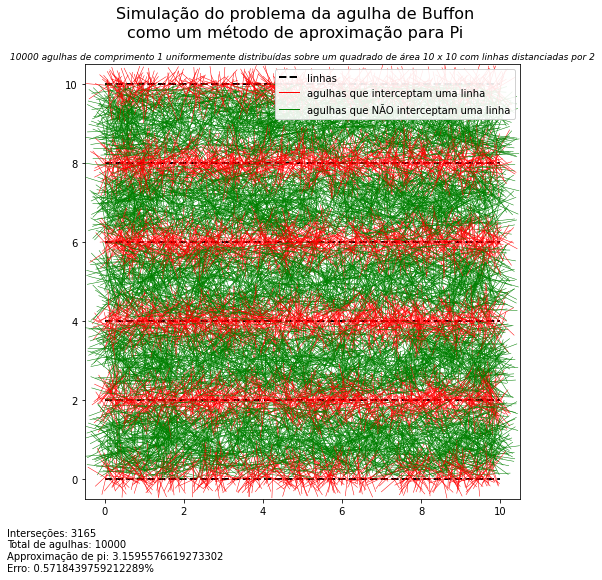

In [18]:
bsim = Buffon_Sim()
bsim.plot()